In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/rt-iot2022real-time-internet-of-things/RT_IOT2022.csv")

df = df.drop(columns=['Unnamed: 0']) if 'Unnamed: 0' in df.columns else df

# Encode categorical variables (using 'Attack_type' as label)
categorical_columns = ['proto', 'service', 'Attack_type']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Extract features and labels
X = df.drop(columns=['Attack_type']).values
y = df['Attack_type'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Use SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE, training set shape:", X_train_bal.shape, np.bincount(y_train_bal))

# Create PyTorch datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train_bal, dtype=torch.float32),
                              torch.tensor(y_train_bal, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


After SMOTE, training set shape: (908724, 84) [75727 75727 75727 75727 75727 75727 75727 75727 75727 75727 75727 75727]


In [3]:
class TeacherNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int):
        super(TeacherNetwork, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        self.feature_layers = nn.Sequential(*layers)
        self.policy_head = nn.Linear(prev_dim, output_dim)
        
    def forward(self, x):
        features = self.feature_layers(x)
        logits = self.policy_head(features)
        return logits

# Initialize teacher model (larger network)
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
teacher_hidden_dims = [128, 64]
teacher_model = TeacherNetwork(input_dim, teacher_hidden_dims, output_dim)




In [4]:
# Train teacher model
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
teacher_epochs = 30
teacher_model.train()
for epoch in range(teacher_epochs):
    epoch_loss = 0
    for states, labels in train_loader:
        teacher_optimizer.zero_grad()
        logits = teacher_model(states)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        teacher_optimizer.step()
        epoch_loss += loss.item()
    print(f"Teacher Epoch {epoch+1}/{teacher_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate teacher model on test set
teacher_model.eval()
all_teacher_preds = []
all_true = []
with torch.no_grad():
    for states, labels in test_loader:
        logits = teacher_model(states)
        preds = torch.argmax(logits, dim=1)
        all_teacher_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
teacher_accuracy = accuracy_score(all_true, all_teacher_preds)
print(f"Teacher Test Accuracy: {teacher_accuracy:.4f}")

Teacher Epoch 1/30, Loss: 0.0580
Teacher Epoch 2/30, Loss: 0.0317
Teacher Epoch 3/30, Loss: 0.0273
Teacher Epoch 4/30, Loss: 0.0250
Teacher Epoch 4/30, Loss: 0.0250
Teacher Epoch 5/30, Loss: 0.0235
Teacher Epoch 6/30, Loss: 0.0227
Teacher Epoch 7/30, Loss: 0.0218
Teacher Epoch 8/30, Loss: 0.0210
Teacher Epoch 9/30, Loss: 0.0205
Teacher Epoch 10/30, Loss: 0.0201
Teacher Epoch 11/30, Loss: 0.0197
Teacher Epoch 12/30, Loss: 0.0196
Teacher Epoch 13/30, Loss: 0.0191
Teacher Epoch 14/30, Loss: 0.0189
Teacher Epoch 15/30, Loss: 0.0185
Teacher Epoch 16/30, Loss: 0.0182
Teacher Epoch 17/30, Loss: 0.0183
Teacher Epoch 18/30, Loss: 0.0183
Teacher Epoch 19/30, Loss: 0.0182
Teacher Epoch 20/30, Loss: 0.0177
Teacher Epoch 21/30, Loss: 0.0174
Teacher Epoch 22/30, Loss: 0.0175
Teacher Epoch 23/30, Loss: 0.0173
Teacher Epoch 24/30, Loss: 0.0171
Teacher Epoch 25/30, Loss: 0.0170
Teacher Epoch 26/30, Loss: 0.0170
Teacher Epoch 27/30, Loss: 0.0167
Teacher Epoch 28/30, Loss: 0.0165
Teacher Epoch 29/30, Los

In [5]:
class StudentNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int):
        super(StudentNetwork, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.05)
            ])
            prev_dim = hidden_dim
        self.feature_layers = nn.Sequential(*layers)
        self.policy_head = nn.Linear(prev_dim, output_dim)
        self.value_head = nn.Linear(prev_dim, 1)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        features = self.feature_layers(x)
        logits = self.policy_head(features)
        values = self.value_head(features).squeeze(-1)
        return logits, values

class KnowledgeDistillationTrainer:
    def __init__(self, teacher_model, student_model, optimizer, temperature=2.0, alpha=0.5):
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.optimizer = optimizer
        self.temperature = temperature
        self.alpha = alpha  # Balance between soft (distillation) and hard (CE) losses
        self.teacher_model.eval()
    
    def compute_distillation_loss(self, student_logits, teacher_logits, labels):
        soft_targets = F.softmax(teacher_logits / self.temperature, dim=1)
        student_log_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = F.kl_div(student_log_probs, soft_targets, reduction='batchmean') * (self.temperature ** 2)
        hard_loss = F.cross_entropy(student_logits, labels)
        return self.alpha * distillation_loss + (1 - self.alpha) * hard_loss
    
    def train_step(self, states, labels):
        with torch.no_grad():
            teacher_logits = self.teacher_model(states).detach()
        student_logits, _ = self.student_model(states)
        loss = self.compute_distillation_loss(student_logits, teacher_logits, labels)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

# Initialize student model (smaller network)
student_hidden_dims = [64, 32]
student_model = StudentNetwork(input_dim, student_hidden_dims, output_dim)

# Initialize optimizer for student
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# Create distillation trainer
distillation_trainer = KnowledgeDistillationTrainer(teacher_model, student_model, student_optimizer,
                                                      temperature=2.0, alpha=0.7)


In [6]:
student_epochs = 30
student_model.train()
for epoch in range(student_epochs):
    epoch_loss = 0
    for states, labels in train_loader:
        loss = distillation_trainer.train_step(states, labels)
        epoch_loss += loss
    print(f"Student Distillation Epoch {epoch+1}/{student_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# ------------------------------

Student Distillation Epoch 1/30, Loss: 0.1951
Student Distillation Epoch 2/30, Loss: 0.0523
Student Distillation Epoch 3/30, Loss: 0.0415
Student Distillation Epoch 4/30, Loss: 0.0355
Student Distillation Epoch 5/30, Loss: 0.0321
Student Distillation Epoch 6/30, Loss: 0.0299
Student Distillation Epoch 7/30, Loss: 0.0280
Student Distillation Epoch 8/30, Loss: 0.0263
Student Distillation Epoch 9/30, Loss: 0.0253
Student Distillation Epoch 10/30, Loss: 0.0241
Student Distillation Epoch 11/30, Loss: 0.0236
Student Distillation Epoch 12/30, Loss: 0.0227
Student Distillation Epoch 13/30, Loss: 0.0220
Student Distillation Epoch 14/30, Loss: 0.0218
Student Distillation Epoch 15/30, Loss: 0.0210
Student Distillation Epoch 16/30, Loss: 0.0206
Student Distillation Epoch 17/30, Loss: 0.0198
Student Distillation Epoch 18/30, Loss: 0.0197
Student Distillation Epoch 19/30, Loss: 0.0194
Student Distillation Epoch 20/30, Loss: 0.0189
Student Distillation Epoch 21/30, Loss: 0.0190
Student Distillation E

In [7]:

student_model.eval()
all_student_preds = []
all_true = []
with torch.no_grad():
    for states, labels in test_loader:
        logits, _ = student_model(states)
        preds = torch.argmax(logits, dim=1)
        all_student_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

student_accuracy = accuracy_score(all_true, all_student_preds)
student_precision = precision_score(all_true, all_student_preds, average='weighted')
student_recall = recall_score(all_true, all_student_preds, average='weighted')
student_f1 = f1_score(all_true, all_student_preds, average='weighted')
cm = confusion_matrix(all_true, all_student_preds)

print(f"Student Test Accuracy: {student_accuracy:.4f}")
print(f"Student Precision: {student_precision:.4f}")
print(f"Student Recall: {student_recall:.4f}")
print(f"Student F1 Score: {student_f1:.4f}")

Student Test Accuracy: 0.9969
Student Precision: 0.9972
Student Recall: 0.9969
Student F1 Score: 0.9970


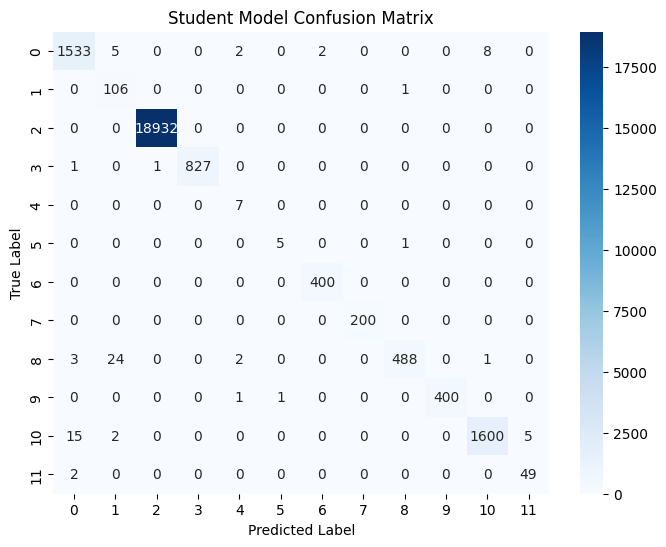

Student model saved as distilled_student_model.pth


In [8]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Student Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# Save the Student Model
# ------------------------------

torch.save(student_model.state_dict(), "distilled_student_model.pth")
print("Student model saved as distilled_student_model.pth")